In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, AveragePooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD, Adam
from keras.datasets import mnist
import numpy as np
from PIL import Image, ImageOps
import argparse
import math

import os
import os.path

Using TensorFlow backend.


In [2]:
def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(Activation('tanh'))
    model.add(Dense(128*8*8))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((128, 8, 8), input_shape=(128*8*8,)))
    model.add(UpSampling2D(size=(4, 4)))
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(4, 4)))
    model.add(Convolution2D(1, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    return model


def discriminator_model():
    model = Sequential()
    model.add(Convolution2D(
                        64, 5, 5,
                        border_mode='same',
                        input_shape=(1, 128, 128)))
    model.add(Activation('tanh'))
    model.add(AveragePooling2D(pool_size=(4, 4)))
    model.add(Convolution2D(128, 5, 5))
    model.add(Activation('tanh'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model


def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model


def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[2:]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[0, :, :]
    return image

In [4]:
model = generator_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
activation_2 (Activation)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 8, 8)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 512, 32, 8)        0         
__________

/Users/sraval/anaconda/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  '` call to the Keras 2 API: ' + signature)
/Users/sraval/anaconda/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
  '` call to the Keras 2 API: ' + signature)
/Users/sraval/anaconda/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), padding="same")`
  '` call to the Keras 2 API: ' + signature)


In [6]:
def load_data(pixels=128):
    print("Loading data")
    X_train = []
    for dirpath, dirnames, filenames in os.walk(".\logos"):
        for filename in [f for f in filenames if f.endswith(".jpg")]:
            #print os.path.join(dirpath, filename)
            im = Image.open(os.path.join(dirpath, filename))
            im = ImageOps.fit(im, (pixels, pixels), Image.ANTIALIAS)
            im = ImageOps.grayscale(im)
            #im.show()
            im = np.asarray(im)
            X_train.append(im)
    print("Finished loading data")
    return np.array(X_train)


In [7]:
X_train = load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape((X_train.shape[0], 1) + X_train.shape[1:])
   

Loading data
Finished loading data


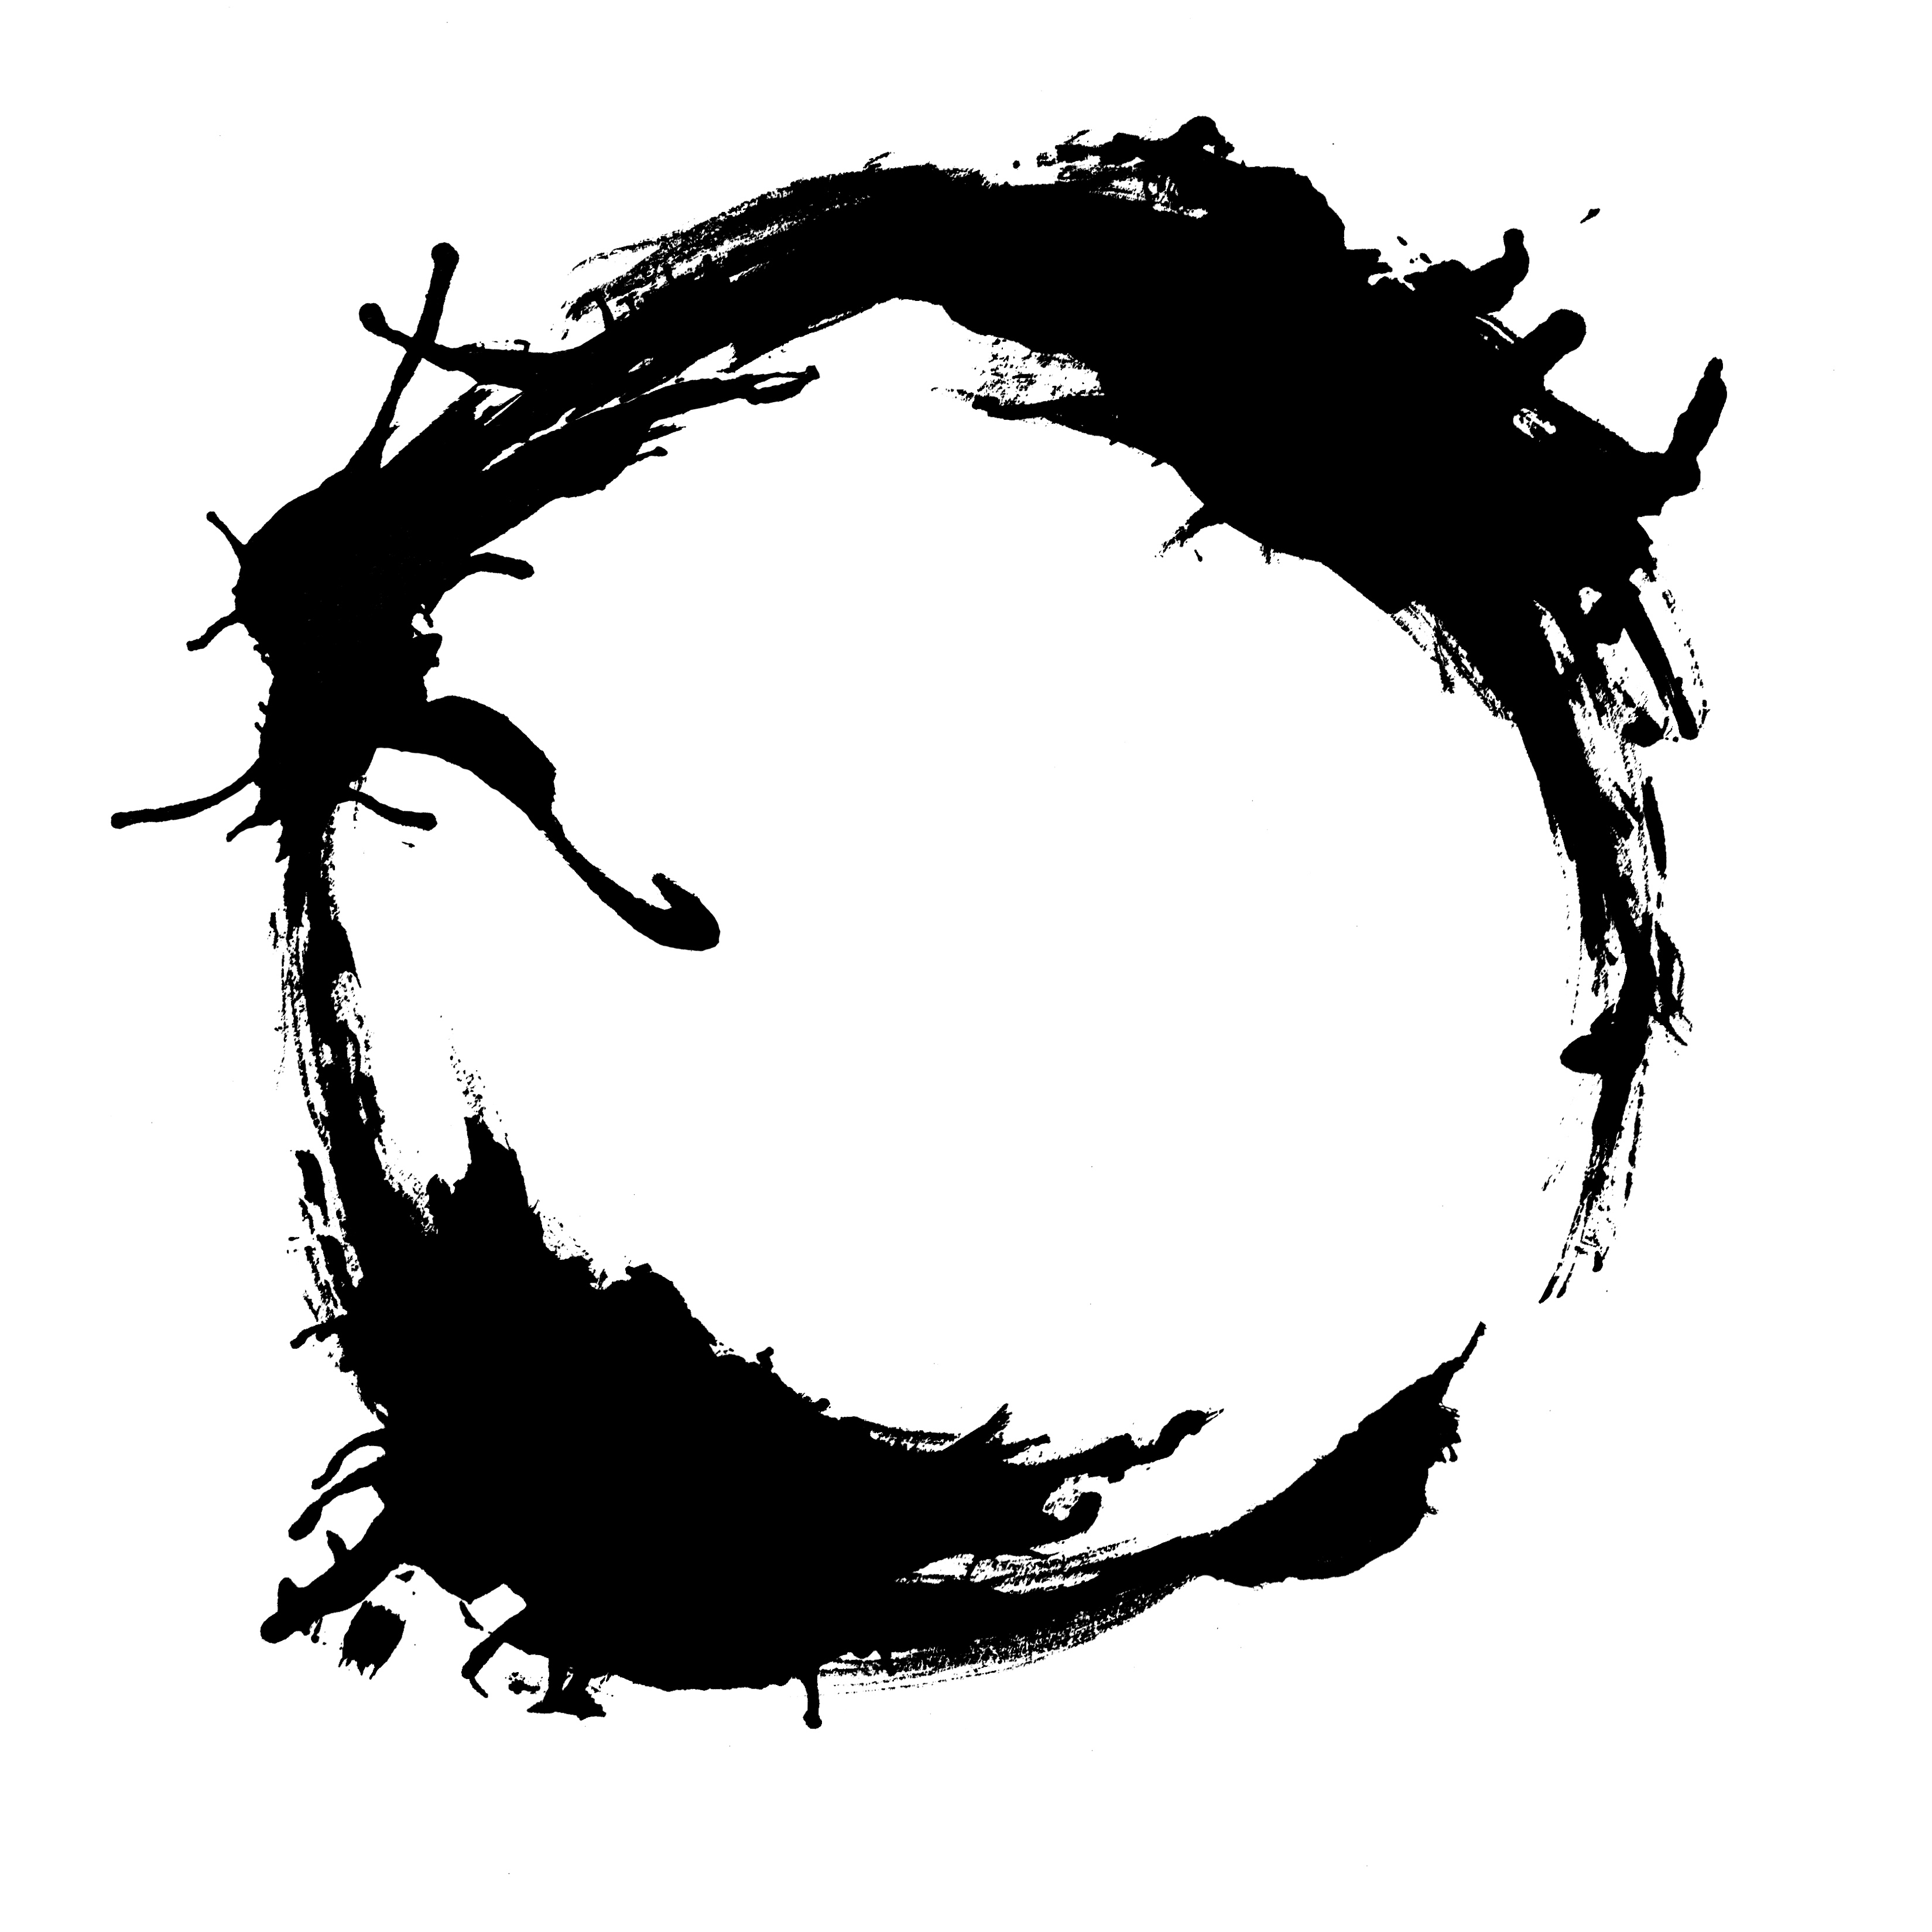

In [14]:
#generate
generate(2)